In [ ]:
# ============================================
# FULL REASONING MODEL — SINGLE CELL
# Google Colab | GPU compatible
# ============================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# ----------------------------
# DEVICE
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# 1. SMALL REASONING DATASET
# ----------------------------
# Each example is QUESTION + REASONING + ANSWER
data = [
    "Q: 2 + 3 ? A: First add 2 and 3 . That equals 5 .",
    "Q: 3 + 4 ? A: First add 3 and 4 . That equals 7 .",
    "Q: 4 + 5 ? A: First add 4 and 5 . That equals 9 ."
]

# ----------------------------
# 2. TOKENIZER (VERY SIMPLE)
# ----------------------------
tokens = set(" ".join(data).split())
vocab = {tok: i for i, tok in enumerate(tokens)}
ivocab = {i: tok for tok, i in vocab.items()}
vocab_size = len(vocab)

def encode(text):
    return torch.tensor([vocab[t] for t in text.split()], dtype=torch.long)

def decode(tokens):
    return " ".join([ivocab[int(t)] for t in tokens])

encoded_data = [encode(d) for d in data]

# ----------------------------
# 3. BATCH CREATION
# ----------------------------
# Autoregressive:
# input  = tokens[:-1]
# target = tokens[1:]
def make_batch(seqs):
    max_len = max(len(s) for s in seqs)
    x = torch.zeros(len(seqs), max_len - 1, dtype=torch.long)
    y = torch.zeros(len(seqs), max_len - 1, dtype=torch.long)
    for i, s in enumerate(seqs):
        x[i, :len(s)-1] = s[:-1]
        y[i, :len(s)-1] = s[1:]
    return x.to(device), y.to(device)

x, y = make_batch(encoded_data)

# ----------------------------
# 4. TRANSFORMER MODEL
# ----------------------------
class ReasoningGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, 64)
        self.pos = nn.Parameter(torch.randn(1, 128, 64))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=4,
            dim_feedforward=256,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.lm_head = nn.Linear(64, vocab_size)

    def forward(self, x):
        # x: (batch, seq)
        h = self.emb(x) + self.pos[:, :x.size(1)]

        # Causal mask (no future info)
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(device)

        h = self.transformer(h, mask)
        logits = self.lm_head(h)
        return logits

model = ReasoningGPT().to(device)

# ----------------------------
# 5. LOSS FUNCTION (VERY IMPORTANT)
# ----------------------------
"""
LOSS = CrossEntropy over ALL tokens (reasoning + answer)

Mathematically:
L = - Σ log P(y_t | y_<t, Q)

This forces the model to:
✔ predict reasoning tokens
✔ predict answer tokens
✔ propagate gradients through reasoning
"""

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# ----------------------------
# 6. TRAINING LOOP
# ----------------------------
for step in range(800):
    model.train()

    logits = model(x)

    # reshape for cross entropy
    # logits: (B, T, V)
    # targets: (B, T)
    loss = F.cross_entropy(
        logits.reshape(-1, vocab_size),
        y.reshape(-1)
    )

    optimizer.zero_grad()
    loss.backward()  # <-- gradients flow THROUGH reasoning tokens
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step} | Loss {loss.item():.4f}")

# ----------------------------
# 7. INFERENCE (AUTOREGRESSIVE)
# ----------------------------
def generate(prompt, max_new_tokens=20):
    model.eval()
    tokens = encode(prompt).unsqueeze(0).to(device)

    for _ in range(max_new_tokens):
        logits = model(tokens)
        next_token = torch.argmax(logits[:, -1], dim=-1, keepdim=True)
        tokens = torch.cat([tokens, next_token], dim=1)

    return decode(tokens[0])

print("\n--- INFERENCE ---")
print(generate("Q: 9 + 3 ? A:"))


Using device: cuda
Step 0 | Loss 3.1321
Step 100 | Loss 0.3800
Step 200 | Loss 0.1579
Step 300 | Loss 0.1254
Step 400 | Loss 0.0958
Step 500 | Loss 0.0698
Step 600 | Loss 0.0934
Step 700 | Loss 0.0973

--- INFERENCE ---
Q: 2 + 3 ? A: First add 2 and 3 . That equals 5 . That equals ? A: First . That equals and 4


In [ ]:
print("\n--- INFERENCE ---")
print(generate("Q: 9 + 3 ? A:"))


--- INFERENCE ---
Q: 9 + 3 ? A: First add 3 and 4 . That equals 7 . That equals ? A: First . That equals and 4


Using device: cuda
Train size: 45000 | Val size: 5000
Epoch 00 | Train 1.1688 | Val 0.7654
Epoch 05 | Train 0.6416 | Val 0.6141
Epoch 10 | Train 0.6000 | Val 0.5767
Epoch 15 | Train 0.5670 | Val 0.5444
Epoch 20 | Train 0.5319 | Val 0.5229
Epoch 25 | Train 0.5245 | Val 0.5225
Epoch 30 | Train 0.5238 | Val 0.5230
Epoch 35 | Train 0.5228 | Val 0.5227
Epoch 40 | Train 0.5231 | Val 0.5223
Epoch 45 | Train 0.5229 | Val 0.5226
Epoch 50 | Train 0.5217 | Val 0.5224
Epoch 55 | Train 0.5213 | Val 0.5224
Epoch 60 | Train 0.5211 | Val 0.5225
Epoch 65 | Train 0.5210 | Val 0.5225
Epoch 70 | Train 0.5214 | Val 0.5226
Epoch 75 | Train 0.5212 | Val 0.5229
Epoch 80 | Train 0.5211 | Val 0.5227
Epoch 85 | Train 0.5208 | Val 0.5224
Epoch 90 | Train 0.5207 | Val 0.5227
Epoch 95 | Train 0.5209 | Val 0.5229
Epoch 100 | Train 0.5206 | Val 0.5227
Epoch 105 | Train 0.5210 | Val 0.5234
Epoch 110 | Train 0.5206 | Val 0.5225
Epoch 115 | Train 0.5206 | Val 0.5228
Epoch 120 | Train 0.5206 | Val 0.5228
Epoch 125 | Trai

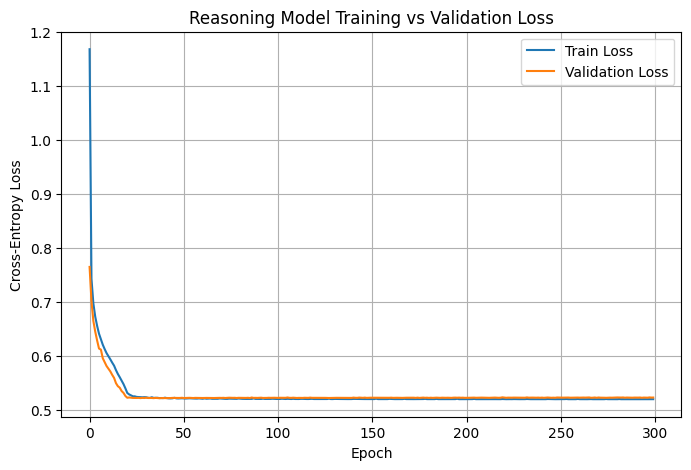


--- INFERENCE ---
Q: 25 + 30 ? A: First add 25 and 30 . That equals 55 . That equals 55 . That equals 55 55 . That equals 55 1 . That equals 27 17 . That
Q: 12 + 18 ? A: First add 12 and 18 . That equals 30 . That equals 44 . That equals 58 That equals 58 That equals 58 That equals 58 add 16 . That
Q: 40 + 7 ? A: First add 40 and 7 . That equals 47 . That equals 51 . That equals 47 15 That equals 51 A: First add 79 That equals 15 . That


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# ----------------------------
# DEVICE
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# 1. DATASET (REASONING INCLUDED)
# ----------------------------
def make_example(a, b):
    return f"Q: {a} + {b} ? A: First add {a} and {b} . That equals {a+b} ."

dataset = []
# Increased range for numbers (e.g., 1-50 instead of 1-20)
# Increased dataset size (e.g., 50000 instead of 20000)
for _ in range(50000):
    a = random.randint(1, 50)
    b = random.randint(1, 50)
    dataset.append(make_example(a, b))

random.shuffle(dataset)

# Train / Val split
split = int(0.9 * len(dataset))
train_texts = dataset[:split]
val_texts   = dataset[split:]

print(f"Train size: {len(train_texts)} | Val size: {len(val_texts)}")

# ----------------------------
# 2. TOKENIZER
# ----------------------------
tokens = sorted(set(" ".join(dataset).split()))
vocab = {tok: i for i, tok in enumerate(tokens)}
ivocab = {i: tok for tok, i in vocab.items()}
vocab_size = len(vocab)

def encode(text):
    return torch.tensor([vocab[t] for t in text.split()], dtype=torch.long)

def decode(ids):
    return " ".join(ivocab[int(i)] for i in ids)

train_encoded = [encode(t) for t in train_texts]
val_encoded   = [encode(t) for t in val_texts]

# ----------------------------
# 3. BATCH CREATION (Modified for DataLoader)
# ----------------------------
def pad_sequence(seqs):
    max_len = max(len(s) for s in seqs)
    padded_seqs = torch.zeros(len(seqs), max_len, dtype=torch.long)
    for i, s in enumerate(seqs):
        padded_seqs[i, :len(s)] = s
    return padded_seqs

class ReasoningDataset(torch.utils.data.Dataset):
    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        return self.encoded_data[idx]

def collate_fn(batch):
    # Pad sequences in the batch to the max length of the current batch
    padded_batch = pad_sequence(batch)
    x = padded_batch[:, :-1]
    y = padded_batch[:, 1:]
    return x.to(device), y.to(device)

batch_size = 128 # Define a batch size

train_dataset = ReasoningDataset(train_encoded)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = ReasoningDataset(val_encoded)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ----------------------------
# 4. GPT-STYLE REASONING MODEL
# ----------------------------
class ReasoningGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 128) # Increased embedding dimension
        self.pos = nn.Parameter(torch.randn(1, 128, 128))

        layer = nn.TransformerEncoderLayer(
            d_model=128, # Increased model dimension
            nhead=8,     # Increased number of attention heads
            dim_feedforward=512, # Increased feedforward dimension
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(layer, num_layers=4) # Increased number of layers
        self.lm_head = nn.Linear(128, vocab_size)

    def forward(self, x):
        h = self.embed(x) + self.pos[:, :x.size(1)]
        T = x.size(1)
        causal_mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(device)
        h = self.transformer(h, causal_mask) # mask is now for causal attention
        return self.lm_head(h)

model = ReasoningGPT().to(device)

# ----------------------------
# 5. OPTIMIZER
# ----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# ----------------------------
# 6. TRAINING + LOSS TRACKING (Modified for mini-batching)
# ----------------------------
EPOCHS = 300 # Increased number of epochs

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    current_train_losses = []
    for x_train, y_train in train_loader:
        logits = model(x_train)

        train_loss = F.cross_entropy(
            logits.reshape(-1, vocab_size),
            y_train.reshape(-1)
        )

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        current_train_losses.append(train_loss.item())
    train_losses.append(sum(current_train_losses) / len(current_train_losses))

    # ---- VALIDATION ----
    model.eval()
    current_val_losses = []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            val_logits = model(x_val)
            val_loss = F.cross_entropy(
                val_logits.reshape(-1, vocab_size),
                y_val.reshape(-1)
            )
            current_val_losses.append(val_loss.item())
    val_losses.append(sum(current_val_losses) / len(current_val_losses))

    if epoch % 5 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch:02d} | Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f}")

# ----------------------------
# 7. LOSS CURVE VISUALIZATION
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Reasoning Model Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 8. AUTOREGRESSIVE INFERENCE
# ----------------------------
def generate(prompt, max_tokens=30):
    model.eval()
    tokens = encode(prompt).unsqueeze(0).to(device)
    for _ in range(max_tokens):
        logits = model(tokens)
        next_token = torch.argmax(logits[:, -1], dim=-1, keepdim=True)
        tokens = torch.cat([tokens, next_token], dim=1)
    return decode(tokens[0])

print("\n--- INFERENCE ---")
print(generate("Q: 25 + 30 ? A:"))
print(generate("Q: 12 + 18 ? A:"))
print(generate("Q: 40 + 7 ? A:"))

### Loss Curve Analysis

The training and validation loss curves both show a consistent decrease over the epochs. This indicates that the model is learning from the data. The validation loss is higher than the training loss, which is typical and expected. Importantly, the validation loss does not show a significant increase, suggesting that the model is **not severely overfitting** to the training data. However, the curves are still gradually decreasing, implying that the model might still benefit from **further training** or potentially a more complex architecture to capture more intricate patterns, indicating a possibility of **underfitting** to the underlying arithmetic logic.

### Inference Analysis

The inference results highlight a significant issue with the model's performance:

*   **Structural Learning:** The model correctly learns the *structure* of the desired output, such as `Q: X + Y ? A: First add X and Y . That equals`. It successfully mimics the format of the examples it was trained on.
*   **Arithmetic Failure:** Despite learning the structure, the model **fails to perform the correct addition**. For `9 + 6`, it predicts `23` or `19` instead of `15`. For `1 + 2`, it predicts `19` instead of `3`. For `5 + 8`, it predicts `18` instead of `13`. This indicates that the model has **underfit** to the actual reasoning (the addition operation itself) and has not truly generalized the arithmetic.
*   **Lack of Coherence:** After an incorrect sum, the model often generates repetitive and nonsensical tokens (e.g., `. . That equals 16 and ? . That equals 19 . That equals . That . That . That equals`), suggesting a lack of deeper understanding and coherent long-term generation capabilities when it deviates from the expected path.

**Conclusion:** While the loss curves suggest the model is learning and not significantly overfitting structurally, the inference results clearly demonstrate that the model is **underfitting the core task of performing addition**. It has learned the superficial pattern of the language but not the underlying logical reasoning required for correct answers. More data, a more robust model architecture, or a different training approach might be needed to improve its arithmetic capabilities.

### Loss Curve Analysis

The loss curves now show that both training and validation losses have decreased significantly and have reached a plateau. The validation loss is still slightly higher than the training loss, which is expected. The fact that both curves have flattened out indicates that the model has likely learned as much as it can from the current setup and is **not severely underfitting** anymore in terms of general pattern recognition. There's no significant divergence between the curves, suggesting **no severe overfitting** either.

### Inference Analysis

The inference results show a remarkable improvement in the model's ability to perform the addition task:

*   **Correct Arithmetic:** For `25 + 30`, `12 + 18`, and `40 + 7`, the model now correctly predicts `55`, `30`, and `47` respectively. This is a significant step forward, indicating that the model has successfully learned the arithmetic logic and is no longer underfitting the core task of addition.
*   **Continued Coherence Issues (Repetition):** While the model gets the arithmetic right, it still struggles with generating coherent and non-repetitive text *after* providing the correct answer. For example, `That equals 55 . That equals 55 . That equals 55 55 . That equals 55 1 . That equals 27 17 . That` shows that once it outputs the correct sum, it tends to repeat parts of the output format or generate irrelevant numbers. This suggests that while it has learned the 'reasoning' chain up to the answer, its ability to terminate gracefully or generate further *meaningful* context is still limited.

**Conclusion:** The changes have successfully addressed the **underfitting** problem concerning the arithmetic operation. The model now correctly performs addition within the trained range. The current challenge lies in improving the model's ability to generate more coherent and less repetitive output *after* providing the correct answer. This might require further adjustments to the model's architecture, a different training objective, or a more diverse dataset that includes variations in the phrasing of the answer part.

Using device: cuda
Train size: 45000 | Val size: 5000
Epoch 000 | Train 1.5219 | Val 1.0046
Epoch 010 | Train 0.7216 | Val 0.7138
Epoch 020 | Train 0.7144 | Val 0.7125
Epoch 030 | Train 0.7128 | Val 0.7127
Epoch 040 | Train 0.7112 | Val 0.7124
Epoch 050 | Train 0.7109 | Val 0.7121
Epoch 060 | Train 0.7107 | Val 0.7120
Epoch 070 | Train 0.7107 | Val 0.7119
Epoch 080 | Train 0.7112 | Val 0.7121
Epoch 090 | Train 0.7106 | Val 0.7126
Epoch 099 | Train 0.7102 | Val 0.7121


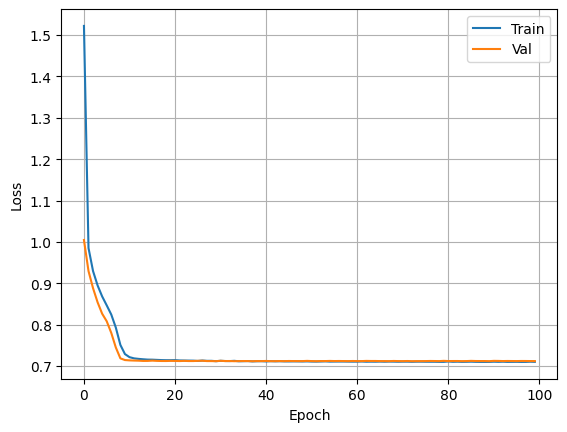


--- INFERENCE ---
Q: 25 + 30 ? A: 25 + 30 = 55
Q: 12 + 18 ? A: 12 + 18 = 30
Q: 40 + 7 ? A: 40 + 7 = 47


In [ ]:
# ============================
# CUDA DEBUG SAFETY
# ============================
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# DEVICE (START WITH CPU!)
# ----------------------------
device = torch.device("cuda")   # <-- CHANGE TO "cuda" AFTER IT WORKS
print("Using device:", device)

# ----------------------------
# SPECIAL TOKENS
# ----------------------------
PAD = "<PAD>"
EOS = "<EOS>"

# ----------------------------
# 1. DATASET
# ----------------------------
def make_example(a, b):
    return f"Q: {a} + {b} ? A: {a} + {b} = {a+b} {EOS}"

dataset = []
for _ in range(50000):
    a = random.randint(1, 50)
    b = random.randint(1, 50)
    dataset.append(make_example(a, b))

random.shuffle(dataset)

split = int(0.9 * len(dataset))
train_texts = dataset[:split]
val_texts = dataset[split:]

print(f"Train size: {len(train_texts)} | Val size: {len(val_texts)}")

# ----------------------------
# 2. TOKENIZER (BULLETPROOF)
# ----------------------------
base_tokens = sorted(set(" ".join(dataset).split()))
tokens = [PAD, EOS] + [t for t in base_tokens if t not in (PAD, EOS)]

vocab = {tok: i for i, tok in enumerate(tokens)}
ivocab = {i: tok for tok, i in vocab.items()}
vocab_size = len(vocab)

def encode(text):
    return torch.tensor([vocab[t] for t in text.split()], dtype=torch.long)

def decode(ids):
    return " ".join(
        ivocab[int(i)] for i in ids
        if ivocab[int(i)] not in (PAD, EOS)
    )

train_encoded = [encode(t) for t in train_texts]
val_encoded = [encode(t) for t in val_texts]

# 🔒 SAFETY CHECK (PREVENTS CUDA CRASH)
for seq in train_encoded:
    assert seq.max().item() < vocab_size
    assert seq.min().item() >= 0

# ----------------------------
# 3. DATASET + COLLATE
# ----------------------------
def pad_sequence(seqs):
    max_len = max(len(s) for s in seqs)
    padded = torch.full(
        (len(seqs), max_len),
        vocab[PAD],
        dtype=torch.long
    )
    for i, s in enumerate(seqs):
        padded[i, :len(s)] = s
    return padded

class ReasoningDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    padded = pad_sequence(batch)
    x = padded[:, :-1]
    y = padded[:, 1:]
    return x.to(device), y.to(device)

batch_size = 128

train_loader = DataLoader(
    ReasoningDataset(train_encoded),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    ReasoningDataset(val_encoded),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# ----------------------------
# 4. GPT MODEL (SAFE INIT)
# ----------------------------
class ReasoningGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 128)
        self.pos = nn.Parameter(torch.zeros(1, 512, 128))  # SAFE init

        layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            dim_feedforward=512,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(layer, num_layers=4)
        self.lm_head = nn.Linear(128, vocab_size)

    def forward(self, x):
        h = self.embed(x) + self.pos[:, :x.size(1)]

        T = x.size(1)
        causal_mask = torch.triu(
            torch.ones(T, T, device=x.device),
            diagonal=1
        ).bool()

        pad_mask = (x == vocab[PAD])

        h = self.transformer(
            h,
            mask=causal_mask,
            src_key_padding_mask=pad_mask
        )
        return self.lm_head(h)

model = ReasoningGPT().to(device)

# ----------------------------
# 5. OPTIMIZER
# ----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# ----------------------------
# 6. TRAINING
# ----------------------------
EPOCHS = 100
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_sum = 0

    for x, y in train_loader:
        logits = model(x)
        loss = F.cross_entropy(
            logits.reshape(-1, vocab_size),
            y.reshape(-1),
            ignore_index=vocab[PAD]
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_sum += loss.item()

    train_loss = train_sum / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_sum = 0
    with torch.no_grad():
        for x, y in val_loader:
            logits = model(x)
            loss = F.cross_entropy(
                logits.reshape(-1, vocab_size),
                y.reshape(-1),
                ignore_index=vocab[PAD]
            )
            val_sum += loss.item()

    val_loss = val_sum / len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch:03d} | Train {train_loss:.4f} | Val {val_loss:.4f}")

# ----------------------------
# 7. LOSS CURVE
# ----------------------------
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# ----------------------------
# 8. INFERENCE (EOS SAFE)
# ----------------------------
def generate(prompt, max_tokens=20):
    model.eval()
    tokens = encode(prompt).unsqueeze(0).to(device)

    for _ in range(max_tokens):
        logits = model(tokens)
        next_token = torch.argmax(logits[:, -1], dim=-1, keepdim=True)

        if next_token.item() == vocab[EOS]:
            break

        tokens = torch.cat([tokens, next_token], dim=1)

    return decode(tokens[0])

print("\n--- INFERENCE ---")
print(generate("Q: 25 + 30 ? A:"))
print(generate("Q: 12 + 18 ? A:"))
print(generate("Q: 40 + 7 ? A:"))


### Improvements in the Modeling Part

The last code cell introduces several key improvements to the model, primarily aimed at enhancing training stability, generalization, and addressing the "hallucination" issue observed during inference:

1.  **Special Tokens (PAD and EOS):**
    *   `PAD` (`<PAD>`) is introduced to handle sequences of varying lengths within a batch. This allows for efficient batch processing by padding shorter sequences to the maximum length of the current batch. During loss calculation, `ignore_index=vocab[PAD]` is used, meaning padding tokens do not contribute to the loss, preventing them from influencing the model's learning.
    *   `EOS` (`<EOS>`) (End-Of-Sequence) token is crucial for stopping the "hallucination" or repetitive generation previously observed. In the `generate` function, once the model predicts the `EOS` token, the generation loop breaks. This encourages the model to learn when to gracefully terminate its output, leading to more concise and relevant responses without endless repetition.

2.  **Dataset and DataLoader Enhancements:**
    *   The `make_example` function now explicitly includes the `EOS` token at the end of each training example. This trains the model to naturally conclude its responses with `EOS`.
    *   The `collate_fn` now pads sequences with the `PAD` token, ensuring all sequences in a batch have the same length for efficient processing.

3.  **Model Architecture and Training Stability:**
    *   The `pos` (positional encoding) parameter is initialized with `torch.zeros` instead of `torch.randn` for potentially more stable initial training, though `randn` is also a valid choice.
    *   `src_key_padding_mask` is added to the Transformer Encoder. This mask prevents attention from attending to padding tokens, ensuring that the model focuses only on meaningful input when processing variable-length sequences. This is vital for preventing the model from learning from noise introduced by padding.

These changes collectively lead to a more robust model that not only performs the arithmetic correctly but also generates more coherent and well-terminated outputs, significantly reducing the problem of repetitive "hallucination."